In [7]:
from music21 import corpus, stream, note
import tensorflow as tf
import math
import random
import functools
import numpy as np

In [8]:
# number of voices
NUM_VOICES = 4

#number of output classes, i.e. half tone differences to melody
NUM_CLASSES = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
TIME_TICK = 0.25

In [139]:
def extractMelody(music):
    min_midi = 256
    max_midi = 0
    melody = []
    currentOffset = 0
    for n in music.parts[0].explode().parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += TIME_TICK;
        noteTicks = math.floor(n.duration.quarterLength / TIME_TICK)
        midiPitch = n.pitches[0].midi
        min_midi = min(min_midi, midiPitch)
        max_midi = max(max_midi, midiPitch)
        if (midiPitch <= 59 or midiPitch >= 83): raise Exception("melody out of range: %d" % midiPitch)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, midiPitch, 1])
            else:
                melody.append([currentOffset, midiPitch, 0])
            currentOffset += TIME_TICK;
    #print("Melody min/max midi pitch: %d/%d" % (min_midi, max_midi))
    return melody

In [10]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to NUM_CLASSES. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    if melody == 0:
        return 0 # we cannot encode voices without melody, convert voice to break
    else:
        diff = melody - voice
        if diff < 0: return 0 # we cannot encode voice above melody , altenative: raise Exception("Error: voice above melody: %d > %d" % (voice, melody))
        # -1 for adding 1 below, additionl -1 so that diff can be index 
        while (diff > NUM_CLASSES - 2):
            diff -= 12
        return diff + 1

In [121]:
def extractVoice(melody, music, part, chordIndex):
# extracts one accompanying voice to melody in the music21.stream music.
# The voice is given as part number and chordPosition
# returns the greatest tick with voices
# 
    maxTick = len(melody); 
    maxVoiceTick = 0
    partNotes = part.flat.notes
    noteIndex = 0
    maxNoteIndex = len(partNotes)
        
    for n in melody:
        #print(n)
        currentOffset = n[0]
        if (noteIndex < maxNoteIndex):
            voiceNote = partNotes[noteIndex]
            if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
               # skip to next note
               noteIndex += 1
        if (noteIndex < maxNoteIndex):                
            voiceNote = partNotes[noteIndex]
            try:
                midiPitch = voiceNote.pitches[chordIndex].midi
            
                maxVoiceTick += 1;
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], midiPitch))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], midiPitch))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)
            except Exception as E:
                print(voiceNote)
                print(voiceNote.offset)
                raise E
    if (maxVoiceTick < maxTick):
        print("    voice is shorter than melody: %d" % maxVoiceTick)
        maxTick = maxVoiceTick

    return maxTick;

In [72]:
def extractVoicesFrom1Chord(melody, music):
# extracts the accompanying voices to melody in the music21.stream music.
# Assumes that the voices are coded as 2 chords with two notes each
# returns the greatest tick with voices
# 
    maxTick = len(melody); 
    if (len(music.parts)) != 1 : raise Exception("1 part expected")

    maxVoiceTick = extractVoice(melody, music, music.parts[0], 1)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick
    maxVoiceTick = extractVoice(melody, music, music.parts[0], 2)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick
    maxVoiceTick = extractVoice(melody, music, music.parts[0], 3)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick

        
    return maxTick;

In [73]:
def extractVoicesFrom2Chords(melody, music):
# extracts the accompanying voices to melody in the music21.stream music.
# Assumes that the voices are coded as 2 chords with two notes each
# returns the greatest tick with voices
# 
    maxTick = len(melody); 
    if (len(music.parts)) != 2 : raise Exception("2 parts expected")

    maxVoiceTick = extractVoice(melody, music, music.parts[0], 1)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick
    maxVoiceTick = extractVoice(melody, music, music.parts[1], 0)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick
    maxVoiceTick = extractVoice(melody, music, music.parts[1], 1)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick

        
    return maxTick;

In [108]:
def extractVoicesFrom2x2Parts(melody, music):
# extracts the accompanying voices to melody in the music21.stream music.
# Assumes that the voices are coded as 2 chords with two notes each
# returns the greatest tick with voices
# 
    maxTick = len(melody); 
    if (len(music.parts)) != 2 : raise Exception("2 parts expected")

    score1 = music.parts[0].explode()
    maxVoiceTick = extractVoice(melody, music, score1.parts[1], 0)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick

    score2 = music.parts[0].explode()
    maxVoiceTick = extractVoice(melody, music, score2.parts[0], 0)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick
    maxVoiceTick = extractVoice(melody, music, score2.parts[1], 0)
    if (maxVoiceTick < maxTick): maxTick = maxVoiceTick

        
    return maxTick;

In [102]:
def extractVoicesFrom4Parts(melody, music):
# extracts the accompanying voices to melody in the music21.stream music.
# returns the greatest tick with voices
# 
    maxTick = len(melody); 
    for partIndex in range(1, min(len(music.parts), 4)):
        maxVoiceTick = extractVoice(melody, music, music.parts[partIndex], 0)
        if (maxVoiceTick < maxTick): maxTick = maxVoiceTick
        
    return maxTick;

In [103]:
def extractVoices(melody, music):
# extracts the accompanying voices to melody in the music21.stream music.
# returns the greatest tick with voices
# 
    numParts = len(music.parts)
    if (numParts == 1) : return extractVoicesFrom1Chord(melody, music)
    elif (numParts == 2) : 
        if (len(music.parts[0].explode().parts) == 2 and
            len(music.parts[1].explode().parts) == 2) :
            return extractVoicesFrom2x2Parts(melody, music)
        else: return extractVoicesFrom2Chords(melody, music)
    else: return extractVoicesFrom4Parts(melody, music)


In [104]:
def trimBreaks(song):
# trims the leading and trailing breaks from the song
    firstNote = -1;
    lastNote = -1;
    for i in range(len(song)):
        if song[i][1] > 0:
            # melody is not a break
            if firstNote == -1: firstNote = i
            lastNote = i
    if lastNote < len(song) - 1:
        print("    Trimming breaks after index %d " % lastNote)
        del song[lastNote + 1:]
        
    if firstNote > 0:
        print("    Trimming breaks before index %d" % firstNote)
        del song[:firstNote]            

In [13]:
def createStream(music, numVoices=4):
# converts a song data structure to a music21 stream
    sc = stream.Score()
    notes = []
    # start 
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    try:
        for tick in music:
            for voice in range (0, numVoices):
                part = sc.parts[voice]
                pitchIndex = 1 + voice * 2
                strikeIndex = 1 + voice * 2 + 1
                # extend note
                #print(tick)
                if notes[voice] != None and tick[strikeIndex] == 0:
                    notes[voice].quarterLength += TIME_TICK            
            
                if tick[strikeIndex] == 1:
                    if (tick[pitchIndex]) > 0:
                        #create new note
                        n = note.Note()
                        notes[voice] = n
                        n.offset = tick[0]
                        if (voice == 0):
                            #melody voice
                            n.pitch.midi = tick[pitchIndex]
                        else:
                            #other voices relative to melody
                            n.pitch.midi = tick[melodyPitchIndex] - tick[pitchIndex] + 1
                        n.quarterLength = TIME_TICK
                        part.append(n)
                    else:
                        n = note.Rest()
                        notes[voice] = n
                        n.offset = tick[0]
                        n.quarterLength = TIME_TICK
                        part.append(n)
    except Exception as E:
        print(E)
        print(voice)
        print(notes)
        print(tick)
                    
    return sc
    
                        

# Add songs to the midi21 corpus

In [ ]:
localCorpus = corpus.corpora.LocalCorpus()
#localCorpus.addPath("/home/lucky/Musik/Midi/Schiefer")
localCorpus.addPath("/home/lucky/Musik/Midi/cpdl.org/Reger")
corpus.cacheMetadata()

In [97]:
for name in localCorpus.getPaths(): 
    if name.find("Reger_EVK10.mxl") >= 0:
        print(name)
        song = corpus.parse(name)
        print(len(song.parts)) 
        print(song.parts[0].explode().parts[1])
        song.show()
        
    

/home/lucky/Musik/Midi/cpdl.org/Reger/Reger_EVK10.mxl
2


IndexError: list index out of range

# create the data
songs: array of extracted song data
streams: array of corresponding music21 stremas

In [140]:
songs = []
streams = []

## add Brahms files

In [141]:
for name in localCorpus.getPaths():
    if name.find("cpdl.org/Reger") >= 0:
        try: 
            song = corpus.parse(name)
            key = song.analyze('key')
            highestTime = song.highestTime
            if True: #len(song.parts) != 4: # and highestTime < 68: 
                # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
                song.transpose(-song.analyze('key').sharps, inPlace = True)
                #song.show()
                notes = extractMelody(song)
                
                maxTick = extractVoices(notes, song)
                # shorten the melody to those parts with accompanying voices
                del notes[maxTick:]
                
                trimBreaks(notes)
                
                songs.append(notes)
                streams.append(song)
                print('%3d: %s: %s, numerator %d, %s voices, duration: %s' % (
                    len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
         
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
            #raise E
    #print(notes)
print("songs: %d" % len(songs) )

  1: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_EVK10.mxl: c minor, numerator 4, 2 voices, duration: 56.0
melody out of range: 55
Error: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_WoOVI-7-4.mxl not expected format, ignored
Error in geting DynamicWedges...Measure no. 8 P1
Error: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_EVK26.mxl not expected format, ignored
  2: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_Macht_hoch_die_Tuer.mxl: A major, numerator 6, 4 voices, duration: 90.0
  3: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_EVK2.mxl: A major, numerator 6, 2 voices, duration: 96.0
  4: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_61d-4.mxl: C major, numerator 4, 4 voices, duration: 36.0
  5: /home/lucky/Musik/Midi/cpdl.org/Reger/Reger_Mit_Fried_und_Freud.mxl: e minor, numerator 4, 2 voices, duration: 52.0
    voice is shorter than melody: 625
    voice is shorter than melody: 625
    voice is shorter than melody: 625
  6: /home/lucky/Musik/Midi/cpdl.org/Reger/Ws-reg-1383.mxl: b minor

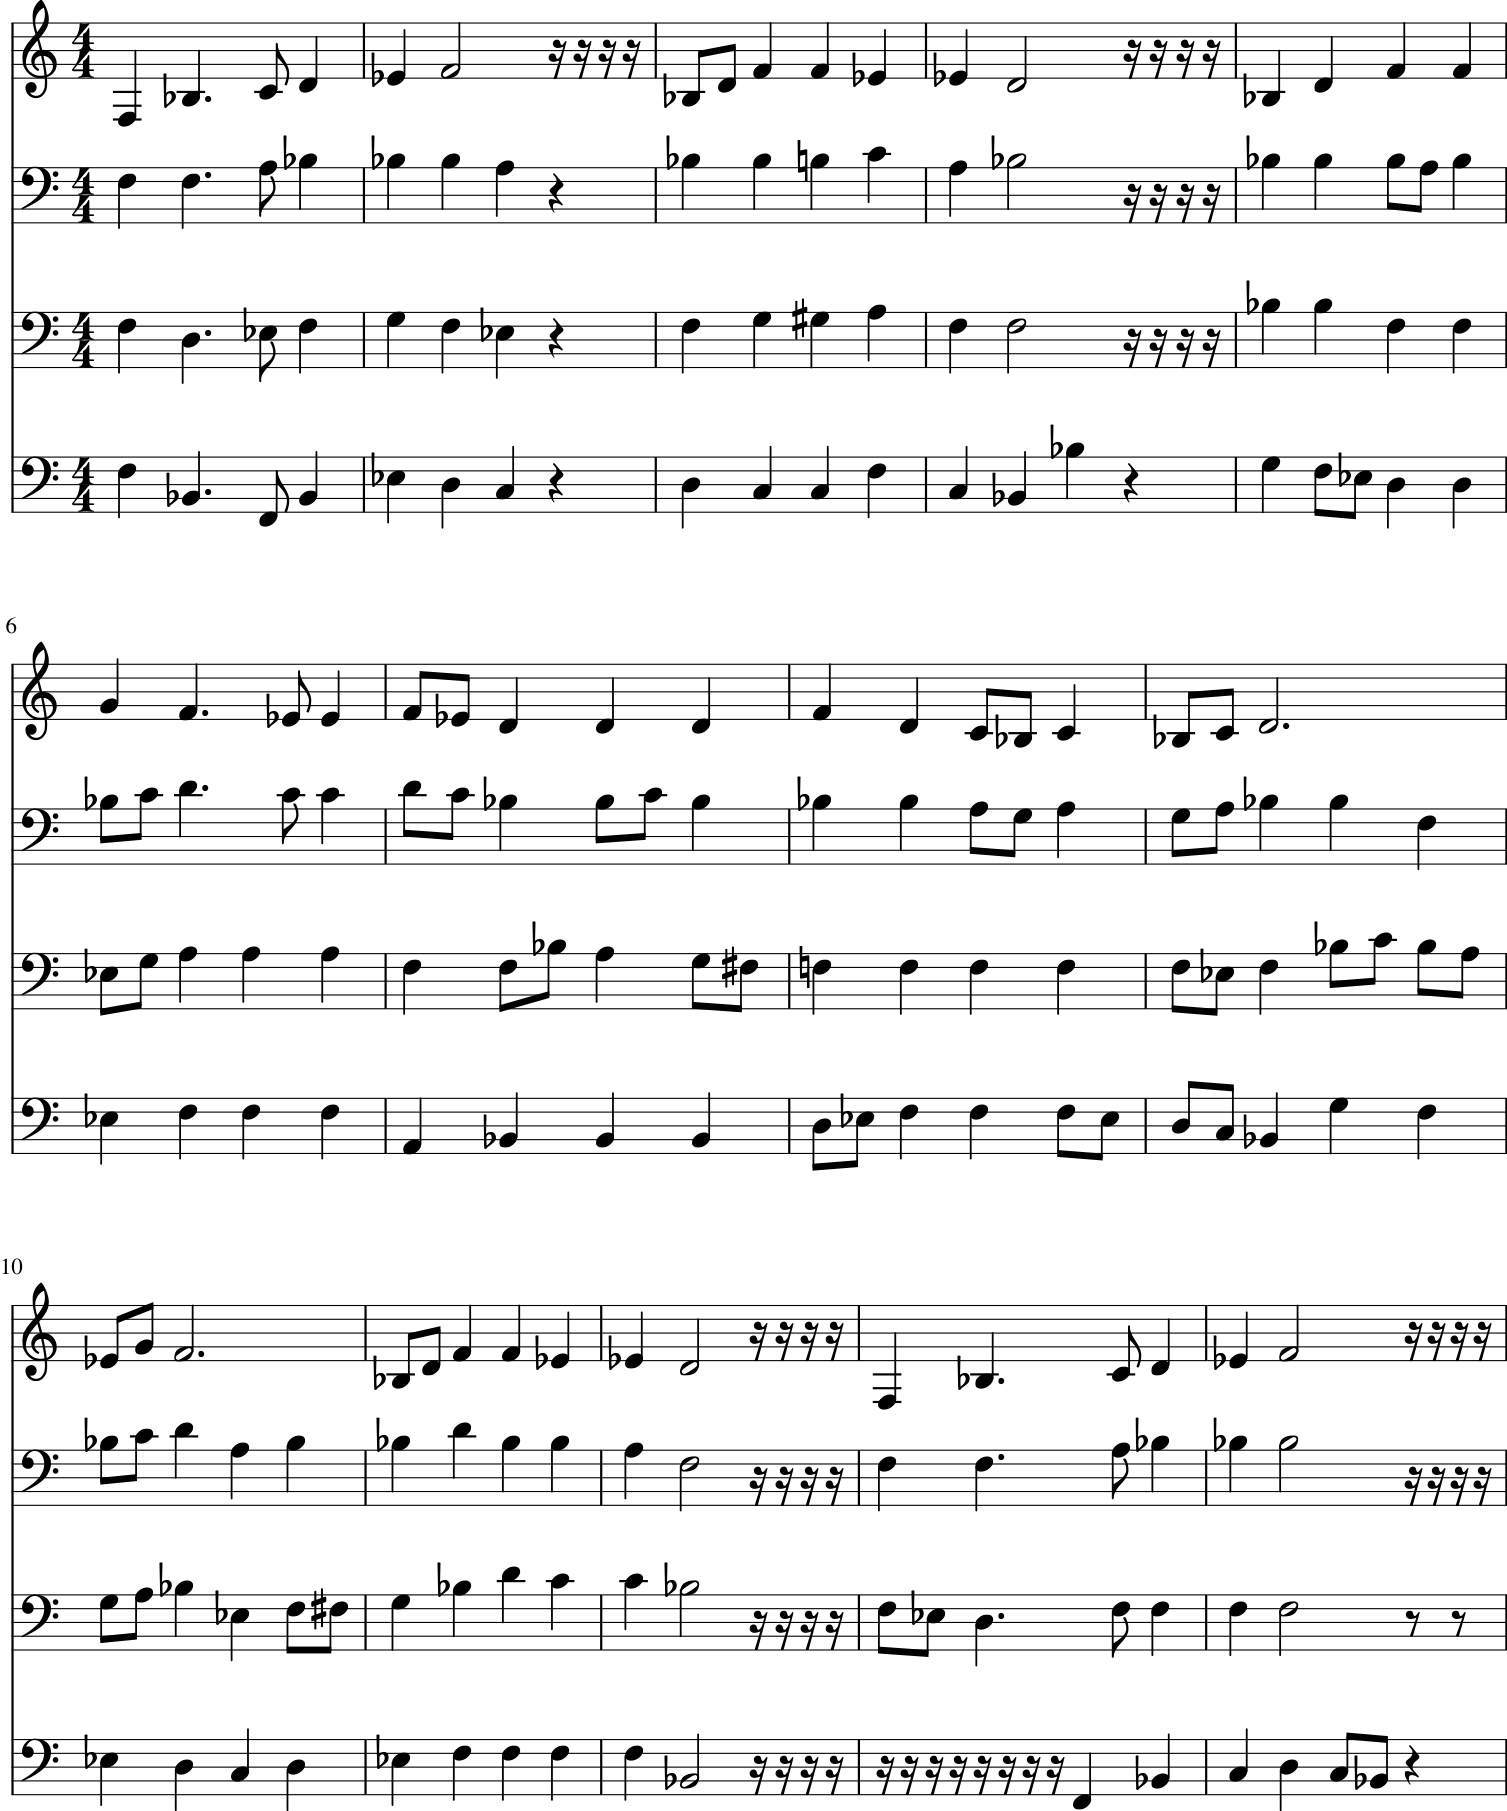

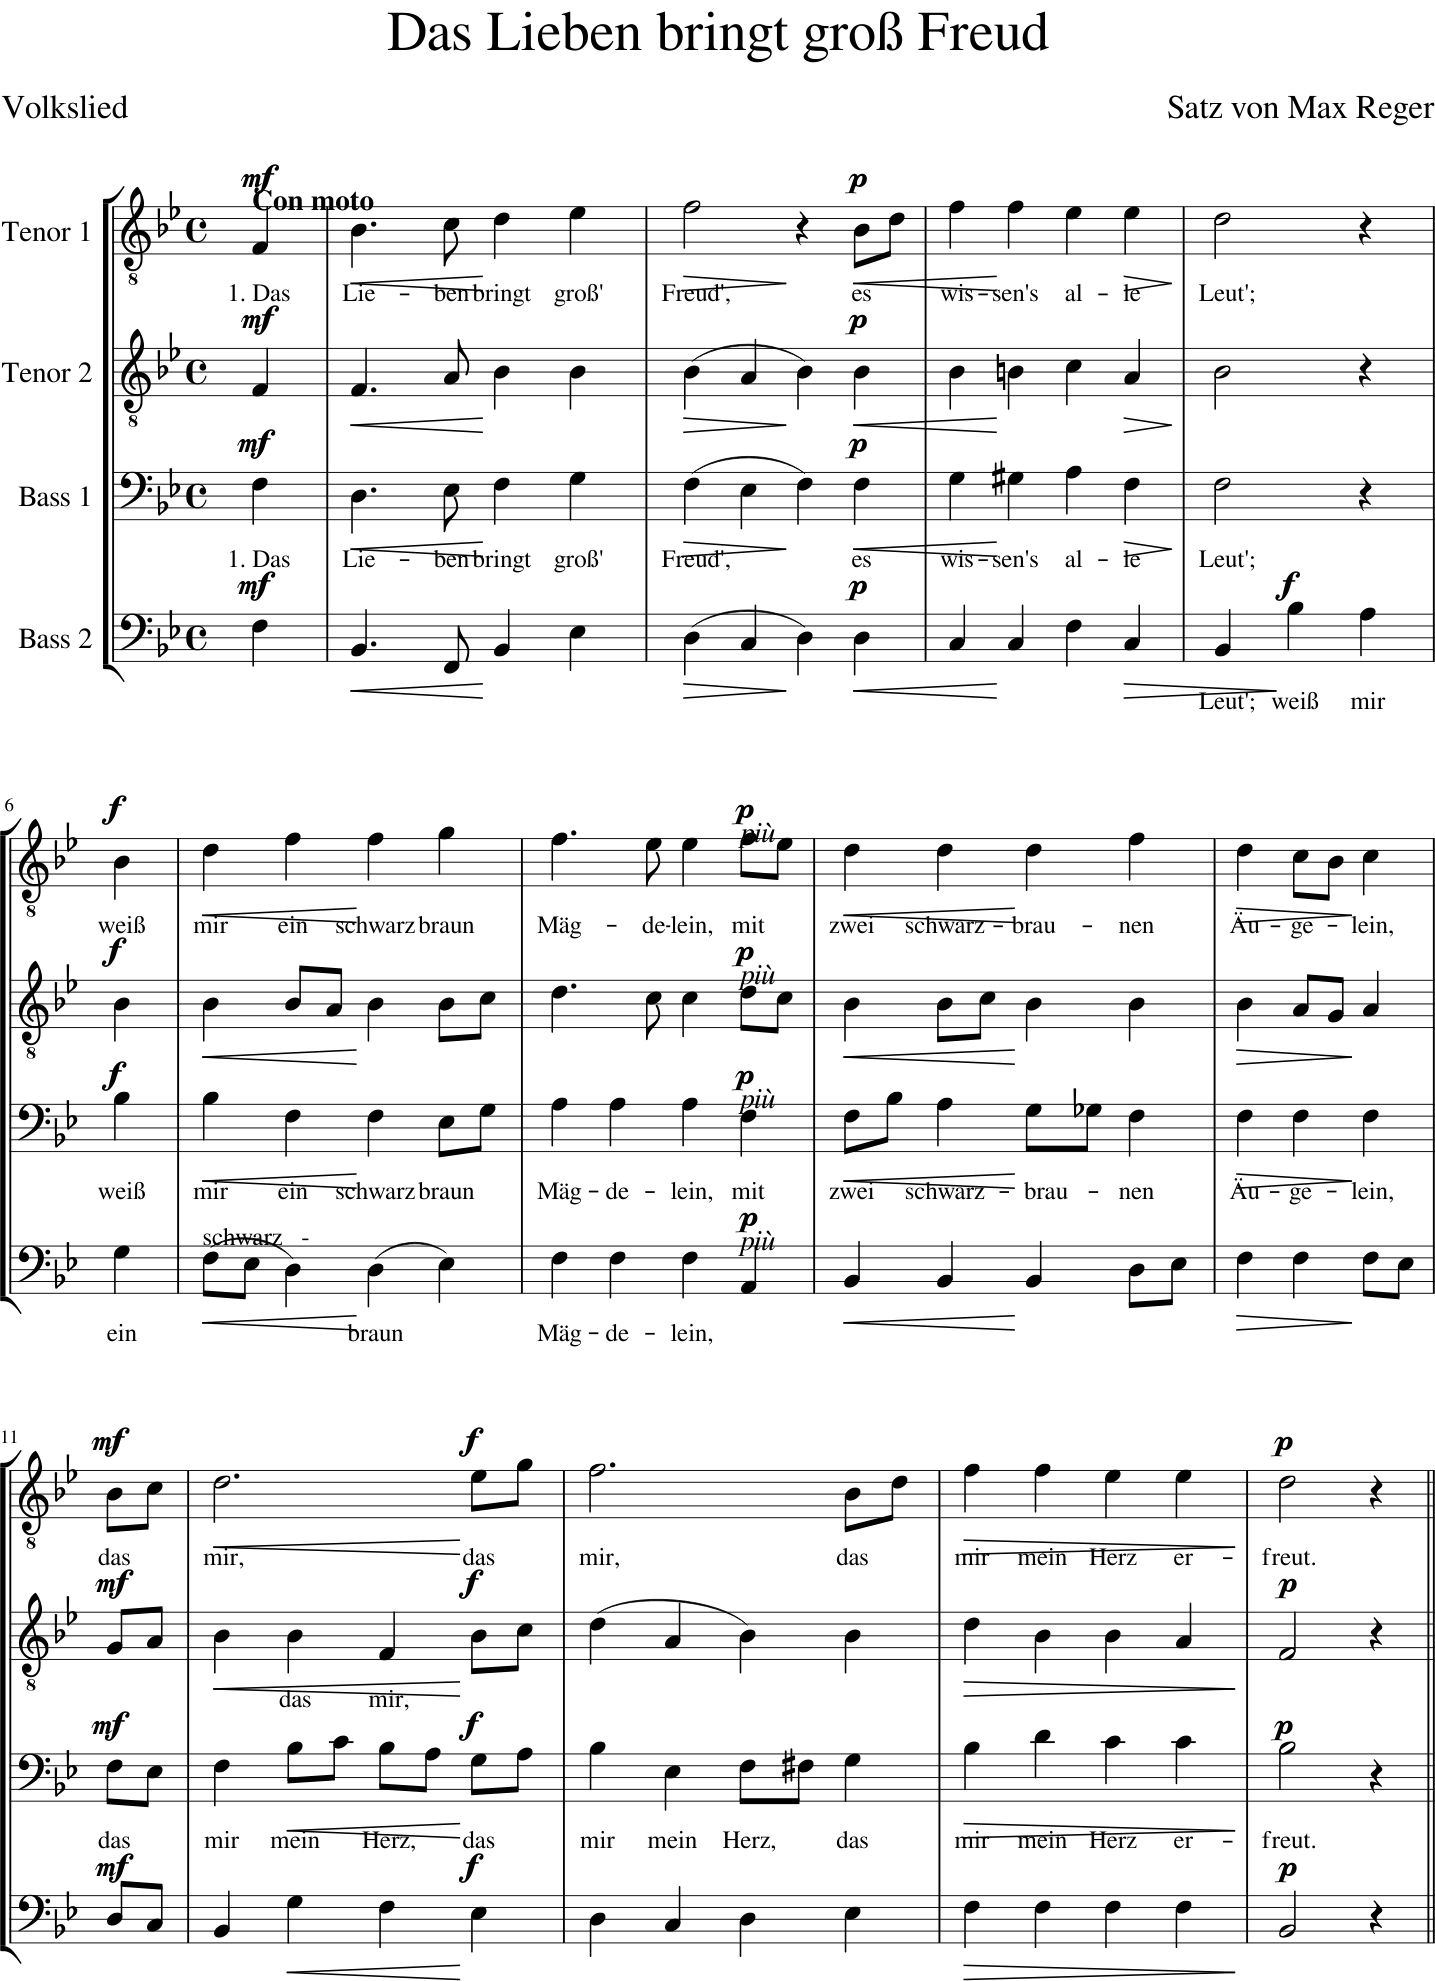

In [129]:
# inspect some of the data
songNum = 41
sc = createStream(songs[songNum], 4)
sc.show()
sc.show('midi')
streams[songNum].show()
sc.show('midi')


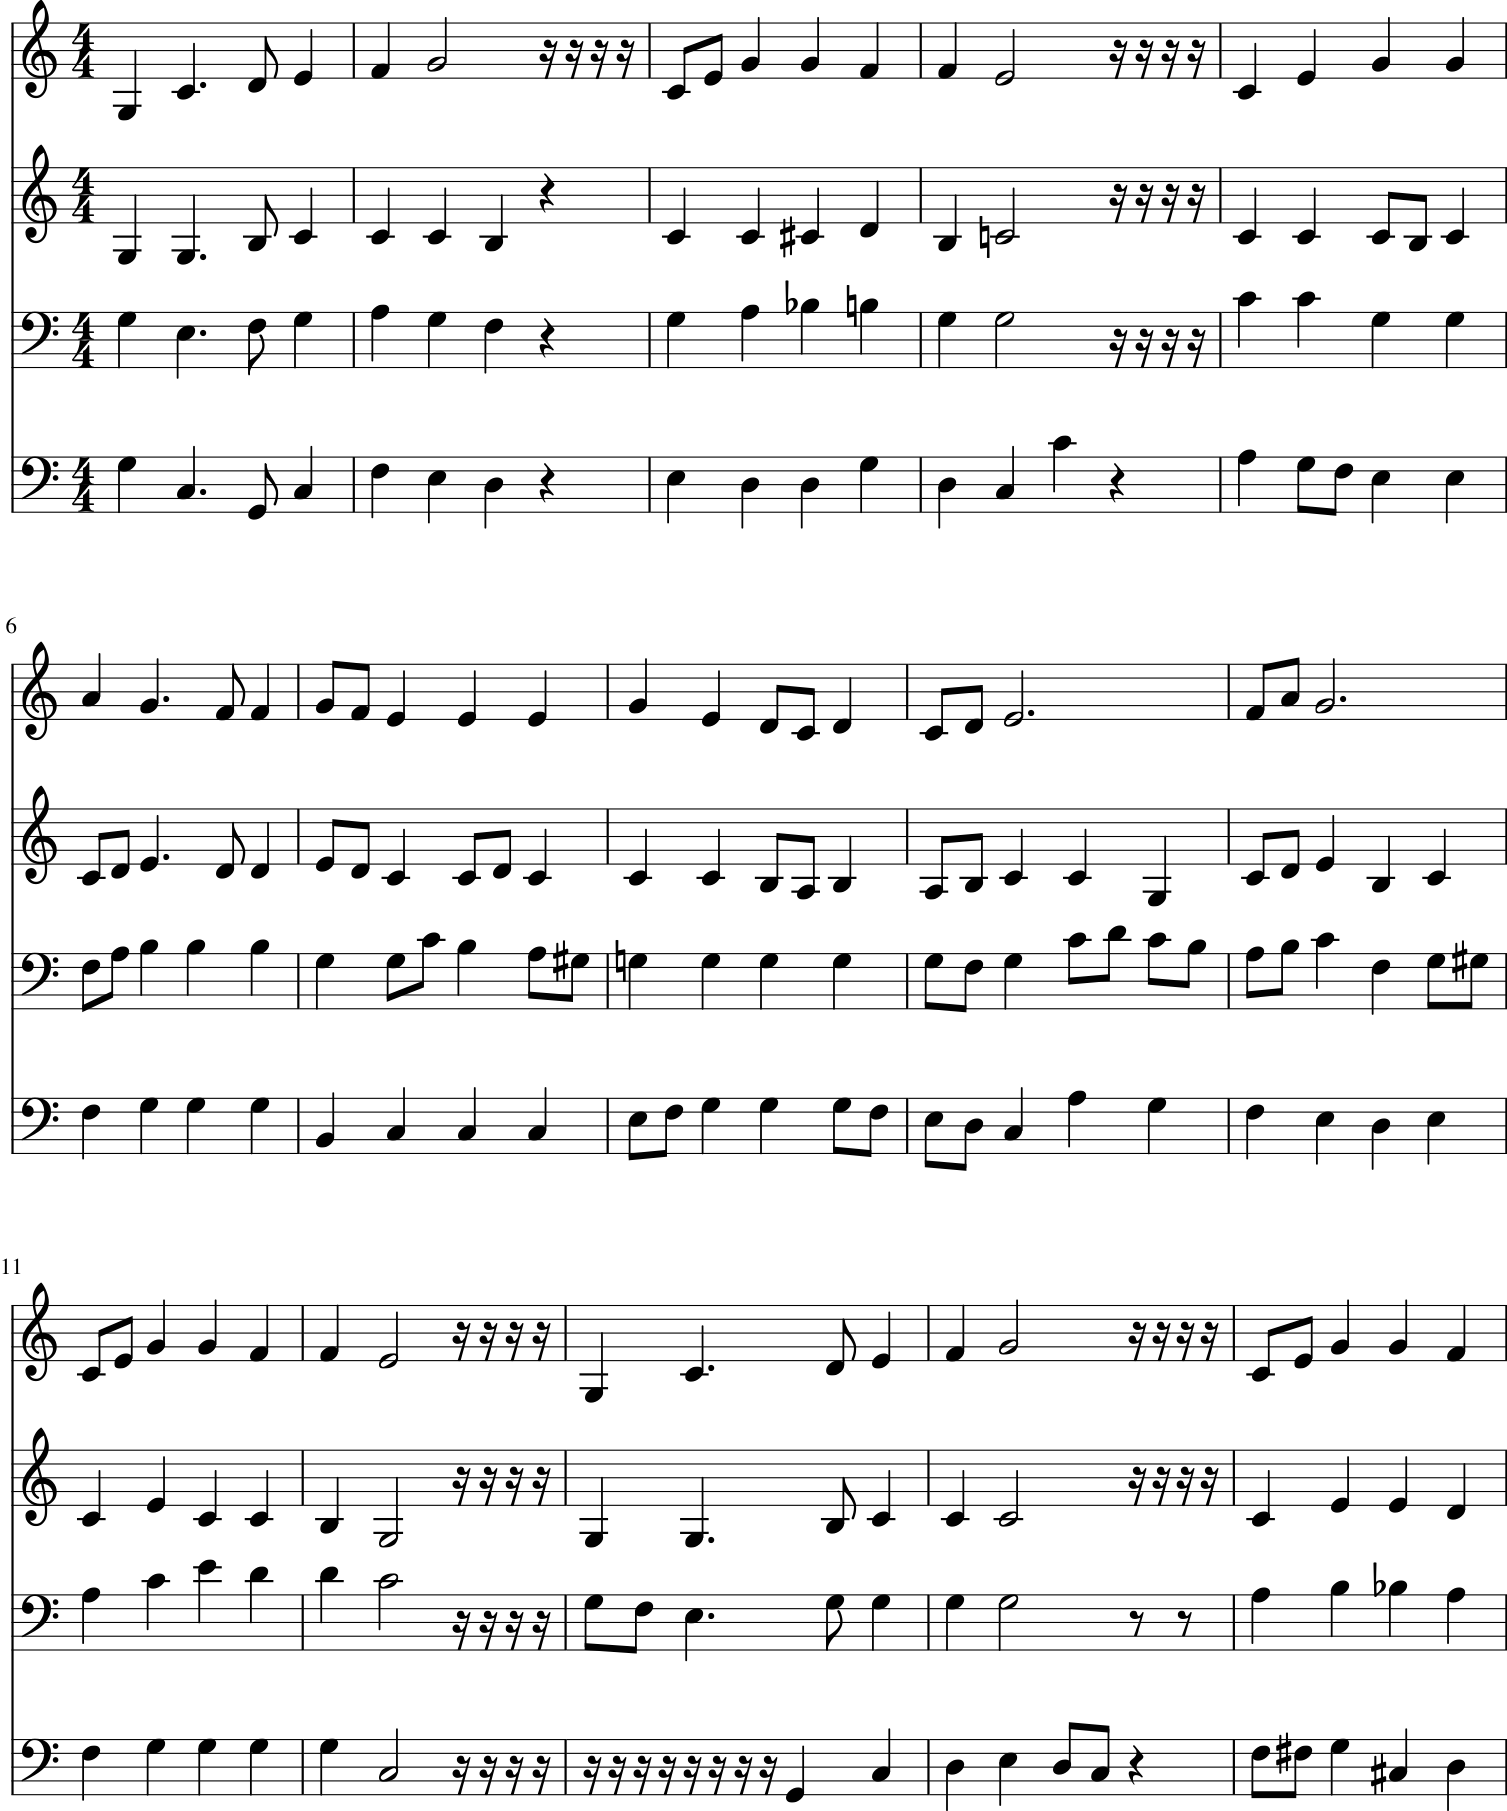

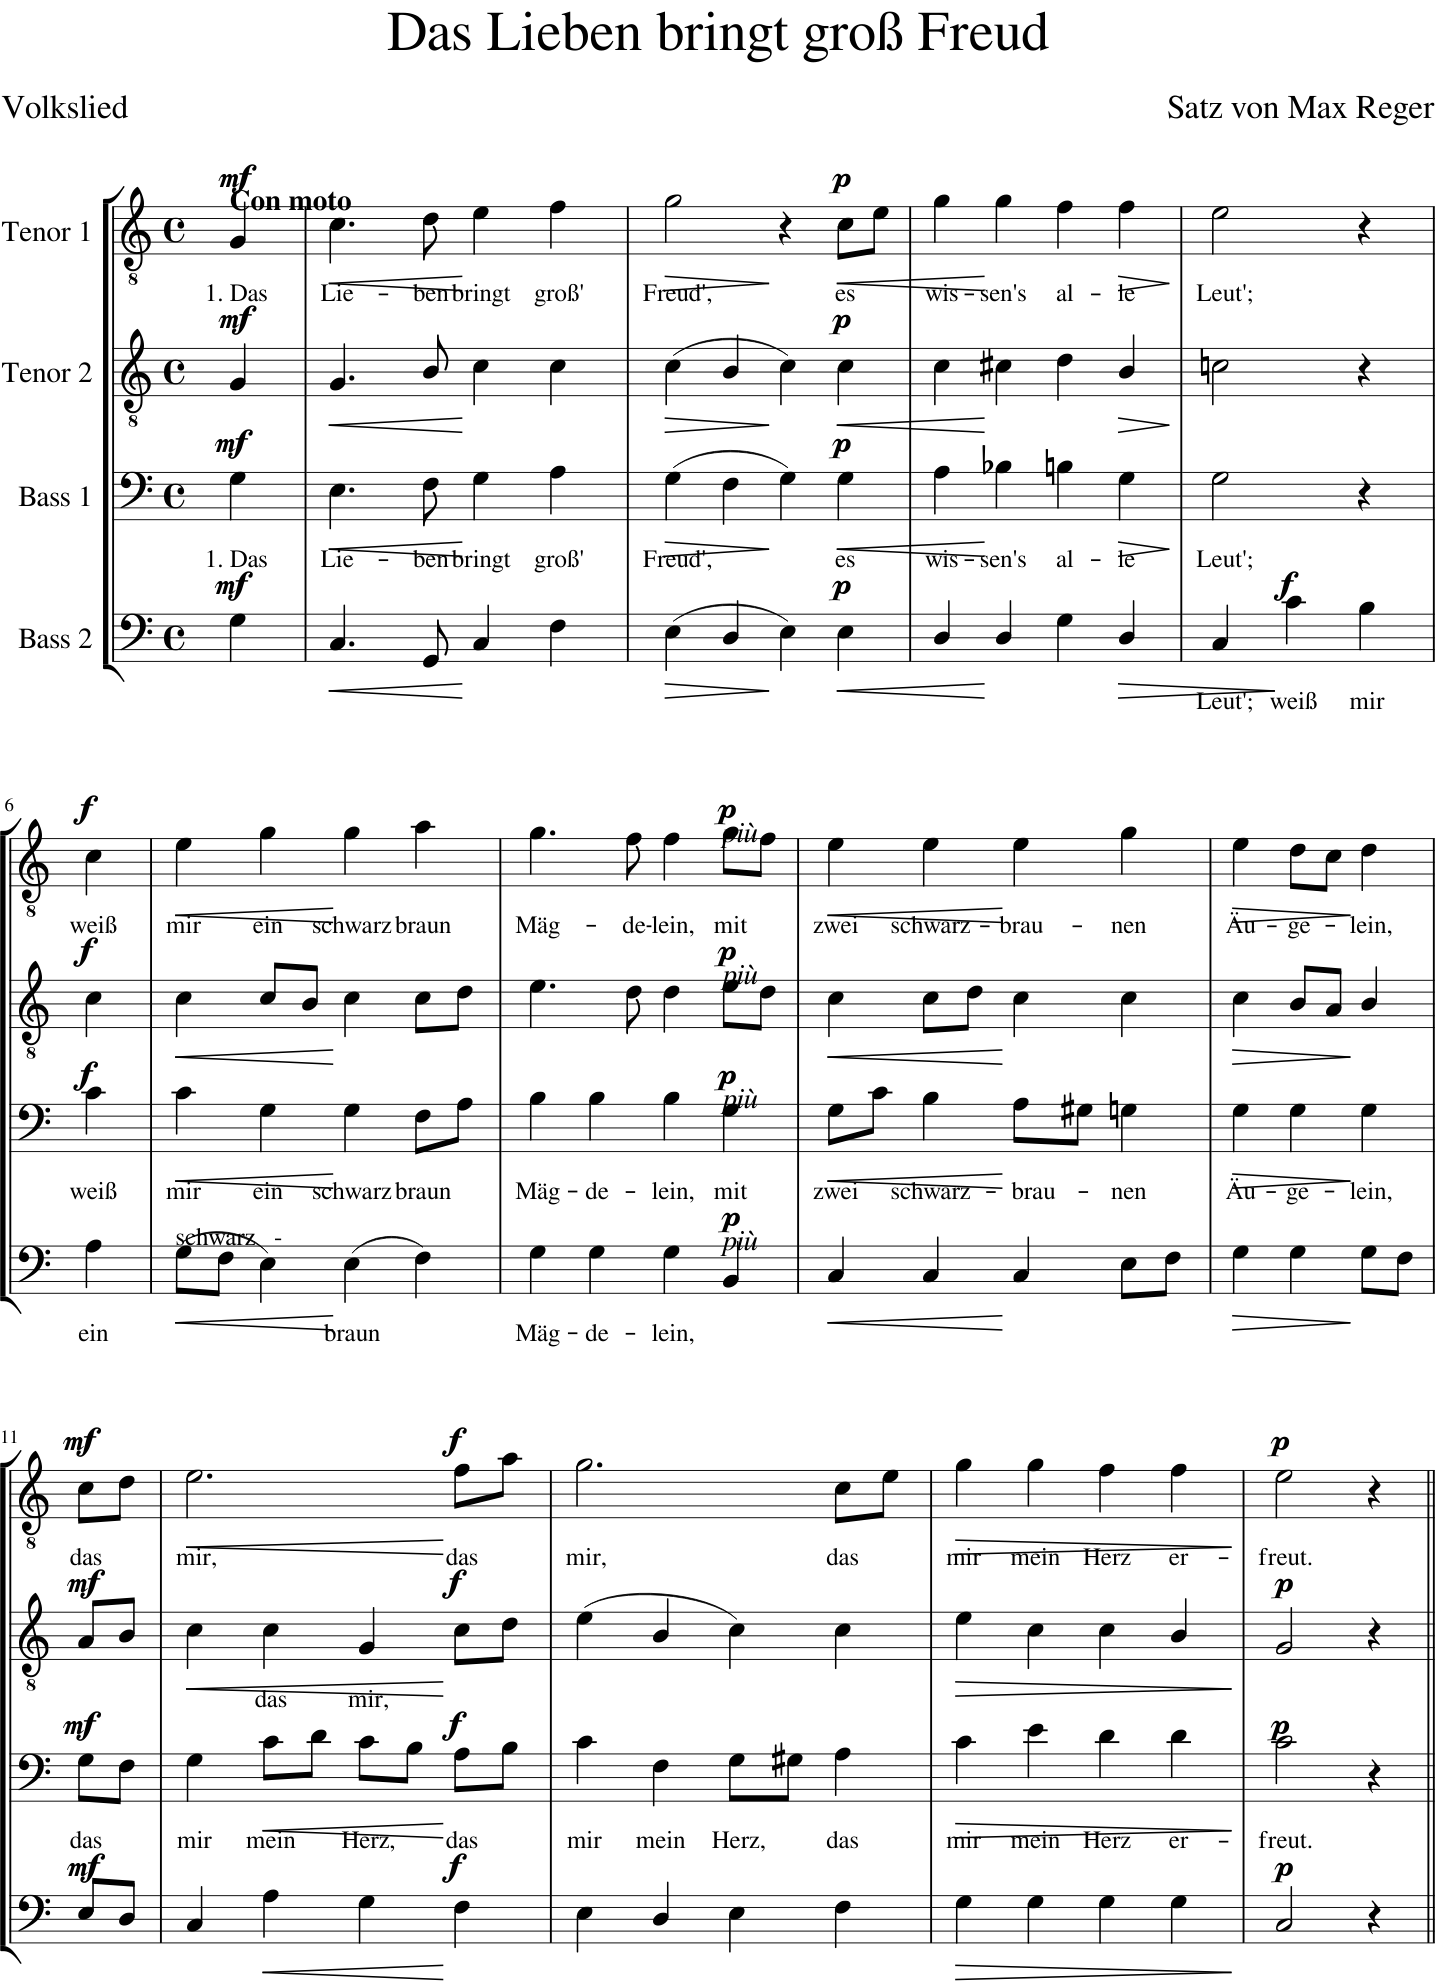

In [131]:
# inspect some of the data
songNum = 81
sc = createStream(songs[songNum], 4)
sc.show()
sc.show('midi')
streams[songNum].show()
sc.show('midi')


## add J.S. Bach chorales

In [12]:
for name in corpus.chorales.Iterator(returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and highestTime < 68: 
        # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            print('%3d: %s: %s, %d, %s voices, duration: %s' % (
                len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/opus48no2.mxl
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/dichterliebe_no2.xml
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/opus41no1/movement1.mxl
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/opus41no1/movement5.mxl
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/opus41no1/movement4.xml
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/opus41no1/movement3.mxl
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/schumann/opus41no1/movement2.mxl
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/oneills1850/0101-0200.abc
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/oneills1850/0626-0635.abc
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/oneills1850/0401-0486.abc
/home/lucky/anaconda3/lib/python3.6/site-packages/musi

/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Kyrie_31_b.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Agnus_II.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Credo_80_d.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Gloria_82_a.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Credo_29_g.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Sanctus_53.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Benedictus_16.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Credo_29_b.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Sanctus_16_a.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Credo_51_b.krn
/home/lucky/anaconda3/lib/python3.6/site-packages/music21/corpus/palestrina/Sanctus_12

  1: bach/bwv153.1: a minor, 4, 4 voices, duration: 56.0
bach/bwv86.6
  2: bach/bwv86.6: E major, 4, 4 voices, duration: 56.0
bach/bwv267
bach/bwv281
  3: bach/bwv281: F major, 4, 4 voices, duration: 32.0
bach/bwv17.7
bach/bwv40.8
bach/bwv248.12-2
  4: bach/bwv248.12-2: G major, 4, 4 voices, duration: 64.0
bach/bwv38.6
bach/bwv41.6
bach/bwv65.2
  5: bach/bwv65.2: a minor, 3, 4 voices, duration: 49.0
bach/bwv33.6
bach/bwv277
  6: bach/bwv277: d minor, 4, 4 voices, duration: 49.0
bach/bwv311
bach/bwv318
  7: bach/bwv318: G major, 4, 4 voices, duration: 52.0
bach/bwv351
  8: bach/bwv351: g minor, 4, 4 voices, duration: 36.0
bach/bwv302
Error: voice above melody
Error: bach/bwv302 not expected format, ignored
bach/bwv153.5
Error: voice above melody
Error: bach/bwv153.5 not expected format, ignored
bach/bwv28.6
  9: bach/bwv28.6: a minor, 4, 4 voices, duration: 64.0
bach/bwv415
 10: bach/bwv415: D major, 4, 4 voices, duration: 64.0
bach/bwv20.11
 11: bach/bwv20.11: F major, 4, 4 voices, dur

 97: bach/bwv401: F major, 4, 4 voices, duration: 60.0
bach/bwv309
bach/bwv300
 98: bach/bwv300: G major, 4, 4 voices, duration: 64.0
bach/bwv341
 99: bach/bwv341: g minor, 4, 4 voices, duration: 36.0
bach/bwv355
100: bach/bwv355: A major, 4, 4 voices, duration: 64.0
bach/bwv408
101: bach/bwv408: g minor, 4, 4 voices, duration: 48.0
bach/bwv410
102: bach/bwv410: g minor, 4, 4 voices, duration: 56.0
bach/bwv400
103: bach/bwv400: E- major, 3, 4 voices, duration: 54.0
bach/bwv364
104: bach/bwv364: g minor, 4, 4 voices, duration: 44.0
bach/bwv365
105: bach/bwv365: a minor, 4, 4 voices, duration: 56.0
bach/bwv306
106: bach/bwv306: F major, 3, 4 voices, duration: 48.0
bach/bwv253
107: bach/bwv253: A major, 4, 4 voices, duration: 40.0
bach/bwv122.6
Error: voice above melody
Error: bach/bwv122.6 not expected format, ignored
bach/bwv140.7
bach/bwv265
108: bach/bwv265: d minor, 4, 4 voices, duration: 32.0
bach/bwv319
109: bach/bwv319: e minor, 4, 4 voices, duration: 44.0
bach/bwv388
110: bach/bw

bach/bwv248.23-2
bach/bwv248.5
Error: voice above melody
Error: bach/bwv248.5 not expected format, ignored
bach/bwv381
197: bach/bwv381: e minor, 4, 4 voices, duration: 60.0
bach/bwv250
bach/bwv70.11
bach/bwv103.6
198: bach/bwv103.6: b minor, 4, 4 voices, duration: 64.0
bach/bwv360
199: bach/bwv360: B- major, 4, 4 voices, duration: 64.0
bach/bwv430
200: bach/bwv430: A major, 4, 4 voices, duration: 60.0
bach/bwv312
bach/bwv112.5
bach/bwv44.7
Error: voice above melody
Error: bach/bwv44.7 not expected format, ignored
bach/bwv358
bach/bwv422
201: bach/bwv422: C major, 4, 4 voices, duration: 52.0
bach/bwv10.7
bach/bwv261
bach/bwv248.35-3
202: bach/bwv248.35-3: f# minor, 4, 4 voices, duration: 44.0
bach/bwv248.12-2
203: bach/bwv248.12-2: G major, 4, 4 voices, duration: 64.0
bach/bwv248.59-6
bach/bwv395
204: bach/bwv395: A major, 4, 4 voices, duration: 48.0
bach/bwv417
205: bach/bwv417: b minor, 4, 4 voices, duration: 64.0
bach/bwv359
206: bach/bwv359: A major, 4, 4 voices, duration: 64.0
bac

# Build the model

In [148]:
# https://gist.github.com/danijar/61f9226f7ea498abce36187ddaf51ed5
# Example for my blog post at:
# http://danijar.com/introduction-to-recurrent-networks-in-tensorflow/
import functools

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class MusicAccompanistLearning:

    def __init__(self, data, seq_length, target, dropout, num_hidden=200, num_layers=1, NUM_VOICES = 4):
        self.data = data
        self.target = target
        self.dropout = dropout
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.prediction
        self.error
        self.optimize
        #self.update_states

    @lazy_property
    def prediction(self):
        # Recurrent network.
        #cells = [tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)] * self._num_hidden
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            # a lot of fluctuation (8th/16th) in the results between different possible notes.
            # this might be reduced by the peep holes?
            cells.append(tf.nn.rnn_cell.LSTMCell(
                self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = TRue, does not work with undefined btch size
        #self.states = get_state_variables(data.shape[0], network)
        #state = tf.Variable(network.zero_states(data.shape[0], tf.float32), trainable=False)
        
        output, new_states = tf.nn.dynamic_rnn(network, data, dtype=tf.float32, 
                                               sequence_length=self.seq_length) #, initial_state=states)
        
        # Add an operation to update the train states with the last state tensors.
        # if state_is_tuple = True, does not work with undefined btch size
        # self.update_states = get_state_update_op(states, new_states)
        # self.update_states = states.assign(new_states)
        
        # Softmax layer for voices
        max_length = int(self.target.get_shape()[1])
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_CLASSES * (NUM_VOICES - 1))
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction_voices = tf.matmul(output, weight) + bias
        prediction_voices = tf.nn.softmax(tf.reshape(prediction_voices, [-1, max_length, (NUM_VOICES - 1), NUM_CLASSES]))
        print("prediction_voices:", prediction_voices.shape)
        
        # strike layer for voices: 1 
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_VOICES - 1)
        prediction_strike = tf.sigmoid(tf.reshape(tf.matmul(output, weight) + bias, [-1, max_length, NUM_VOICES - 1, 1]))
        print("prediction_strike:", prediction_strike.shape)
        
        prediction = tf.concat(axis = 3, values = [prediction_voices, prediction_strike])
        print("prediction:", prediction.shape)
        
        return prediction

    @lazy_property
    def cost(self):
        # Compute cross entropy for each frame.
        cross_entropy = target * tf.log(tf.clip_by_value(self.prediction, 1e-10, 1.0)) \
            + (1 - target) * tf.log(tf.clip_by_value(1 - self.prediction, 1e-10, 1.0))
        cross_entropy = -tf.reduce_sum(cross_entropy, [2, 3])
        # mask out padding. ToDo: also rests have target value of 0
        mask = tf.sign(tf.reduce_max(tf.abs(target), [2, 3]))
        cross_entropy *= mask
        # Average over actual sequence lengths.
        cross_entropy = tf.reduce_sum(cross_entropy, 1)
        cross_entropy /= tf.reduce_sum(mask, 1)
        return tf.reduce_mean(cross_entropy)        

    @lazy_property
    def optimize(self):
        learning_rate = 0.003
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        #optimizer = tf.train.AdamOptimizer(learning_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 3), tf.argmax(self.prediction, 3))
        mistakes = tf.cast(mistakes, tf.float32)
        return tf.reduce_mean(tf.cast(mistakes, tf.float32))

    @staticmethod
    def _weight_and_bias(in_size, out_size, name_postfix=''):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight, name='weight' + name_postfix), tf.Variable(bias, name='bias' + name_postfix)


def read_dataset(songs, NUM_VOICES = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print("max sequence length: ", max_seq_length)
    
    m = len(songs)  
    print("num samples: ", m)
    X=[]
    Y=[]
    # fill again, if an exception occurs, not all songs might be transferred
    seq_length = []
    for sg in songs:
        try:
            x=[]
            y=[]
            #print(sg)
            for tick in sg:
                #print(tick)
                melody = []
                # encode as halftones (2 octaves) above C-3 (59)
                oneHot = np.zeros(NUM_CLASSES)
                pitch = tick[1]
                # one-hot encode the pitch. A break is empty.
                if (pitch >= 59 and pitch < 83):
                    oneHot[tick[1] - 59] = 1
                elif pitch != 0:
                    print(pitch)
            
                # add strike
                melody = np.append(oneHot, tick[2])
            
            
                voices = []
                for voice in range(NUM_VOICES - 1):
                    voice_index = 3 + voice * 2
                    oneHot = np.zeros(NUM_CLASSES)
                    #print(tick)
                    oneHot[tick[voice_index]] = 1
                    # add strike
                    voiceCode = np.append(oneHot, tick[voice_index + 1])
                    #print(oneHot)
                    voices.append(voiceCode)
                    
                x.append(melody)
                y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
            # pad songs
            padding_length = max_seq_length - len(x)
            #print("padding:", padding_length)
            for i in range (0, padding_length):
                x.append([0] * (NUM_CLASSES + 1))
                voices = []
                for voice in range(NUM_VOICES - 1):
                    voices.append(np.zeros(NUM_CLASSES + 1))
                y.append(voices)
            X.append(x)
            Y.append(y)   
            seq_length.append(len(sg))
        except Exception as E:
            print(E)
    #print(Y[0])
    data = np.array(X)
    print("data: ", data.shape)
    target = np.array(Y)
    print("target: ", target.shape)
    dataset = {'data': data , 'target' : target, 'seq_length' : np.array(seq_length)}
    # ToDo: split training and test set already here. Generelization on the test set can only be evaluated manually, 
    # there is no "right" accompanying voice. 
    train, test = dataset, dataset
    return train, test


if __name__ == '__main__':
    tf.reset_default_graph()
    train, test = read_dataset(songs)
    _, length, input_size = train['data'].shape
    data = tf.placeholder(tf.float32, [None, length, input_size], name = "input")
    target = tf.placeholder(tf.float32, [None, length, NUM_VOICES - 1, NUM_CLASSES + 1], name = "target")
    seq_length = tf.placeholder(tf.float32, [None], name = "seq_length")
    dropout = tf.placeholder(tf.float32, name = "dropout")
    model = MusicAccompanistLearning(data, seq_length, target, dropout, num_hidden = 300, num_layers=3)
    sess = tf.Session()
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())

max sequence length:  800
num samples:  38
list index out of range
data:  (37, 800, 27)
target:  (37, 800, 3, 27)
prediction_voices: (?, 800, 3, 26)
prediction_strike: (?, 800, 3, 1)
prediction: (?, 800, 3, 27)


# Perform the training and save the model

In [150]:
# Optional: load a pretrained model
all_saver = tf.train.Saver()
all_saver.restore(sess, "/home/lucky/models/Reger")


INFO:tensorflow:Restoring parameters from /home/lucky/models/Reger


In [153]:
random.seed(1)
max_song = min(999, len(songs))
for epoch in range(1000):
    batchsize = random.randint(5, 7)
    for batchnum in range(math.floor(max_song / batchsize)):
        batch_start = batchnum * batchsize
        batch_end = batchnum * batchsize + batchsize
        batch_end = min(max_song, batch_end)
        batch_data = train['data'][batch_start : batch_end]
        batch_target = train['target'][batch_start : batch_end]
        batch_seq_length = train['seq_length'][batch_start : batch_end]
        #batch = train #.sample(10)
        sess.run(model.optimize, {
            data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 0.5})
        error_batch = sess.run(model.cost, {
            data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 1})
        print('   Batch {:2d} {:2d}-{:2d} error {:3.3f}'.format(batchnum + 1, batch_start, batch_end, error_batch))
    #error = sess.run(model.error, {
    #    data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
    error = 0
    prediction = sess.run(model.prediction, {
        data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
    for i in range(10): #test['seq_length'][0]):
        targ = np.argmax(test['target'][0, i, 0, :NUM_CLASSES - 1])
        tstrike = test['target'][0, i, 0, NUM_CLASSES]
        pred = np.argmax(prediction[0, i, 0, :NUM_CLASSES - 1])
        predStrike = prediction[0, i, 0, NUM_CLASSES]
        print("%d %s (%.2f) - %.2f %s (%.2f)" % (
            tstrike, targ, prediction[0, i, 0, targ], predStrike, pred, prediction[0, i, 0, pred]))
        #print(batch['target'][0][0])
    print('Epoch {:2d} error {:3.1f}% --------------------------------'.format(epoch + 1, 100 * error))
            

   Batch  1  0- 5 error 1.392
   Batch  2  5-10 error 2.260
   Batch  3 10-15 error 2.459
   Batch  4 15-20 error 2.685
   Batch  5 20-25 error 3.528
   Batch  6 25-30 error 5.082
   Batch  7 30-35 error 2.337
1 6 (0.60) - 1.00 6 (0.60)
0 6 (0.76) - 0.18 6 (0.76)
0 6 (0.94) - 0.00 6 (0.94)
0 6 (0.93) - 0.01 6 (0.93)
1 6 (0.03) - 0.99 8 (0.59)
0 6 (0.11) - 0.01 8 (0.55)
0 6 (0.05) - 0.04 8 (0.80)
0 6 (0.03) - 0.10 8 (0.66)
1 6 (0.10) - 1.00 8 (0.67)
0 6 (0.39) - 0.01 9 (0.40)
Epoch  1 error 0.0% --------------------------------
   Batch  1  0- 7 error 1.609
   Batch  2  7-14 error 1.981
   Batch  3 14-21 error 2.445
   Batch  4 21-28 error 1.974
   Batch  5 28-35 error 1.524
1 6 (0.67) - 1.00 6 (0.67)
0 6 (0.66) - 0.10 6 (0.66)
0 6 (0.89) - 0.00 6 (0.89)
0 6 (0.85) - 0.00 6 (0.85)
1 6 (0.01) - 0.99 8 (0.55)
0 6 (0.02) - 0.00 8 (0.63)
0 6 (0.02) - 0.03 8 (0.76)
0 6 (0.01) - 0.00 8 (0.76)
1 6 (0.60) - 0.98 6 (0.60)
0 6 (0.77) - 0.00 6 (0.77)
Epoch  2 error 0.0% ---------------------------

   Batch  2  7-14 error 0.871
   Batch  3 14-21 error 1.294
   Batch  4 21-28 error 0.725
   Batch  5 28-35 error 0.325
1 6 (0.76) - 1.00 6 (0.76)
0 6 (0.81) - 0.20 6 (0.81)
0 6 (0.95) - 0.00 6 (0.95)
0 6 (0.93) - 0.00 6 (0.93)
1 6 (0.08) - 1.00 8 (0.51)
0 6 (0.15) - 0.01 8 (0.61)
0 6 (0.11) - 0.01 8 (0.70)
0 6 (0.04) - 0.00 8 (0.81)
1 6 (0.92) - 0.98 6 (0.92)
0 6 (0.99) - 0.00 6 (0.99)
Epoch 17 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.194
   Batch  2  5-10 error 0.815
   Batch  3 10-15 error 1.622
   Batch  4 15-20 error 3.398
   Batch  5 20-25 error 2.967
   Batch  6 25-30 error 5.645
   Batch  7 30-35 error 1.614
1 6 (0.62) - 1.00 6 (0.62)
0 6 (0.80) - 0.18 6 (0.80)
0 6 (0.96) - 0.00 6 (0.96)
0 6 (0.92) - 0.04 6 (0.92)
1 6 (0.08) - 1.00 5 (0.31)
0 6 (0.16) - 0.01 5 (0.64)
0 6 (0.33) - 0.02 6 (0.33)
0 6 (0.14) - 0.01 8 (0.56)
1 6 (0.97) - 0.98 6 (0.97)
0 6 (0.99) - 0.00 6 (0.99)
Epoch 18 error 0.0% --------------------------------
   Batch  1  0- 7 error 

   Batch  6 30-36 error 1.131
1 6 (0.61) - 1.00 6 (0.61)
0 6 (0.67) - 0.34 6 (0.67)
0 6 (0.95) - 0.01 6 (0.95)
0 6 (0.94) - 0.00 6 (0.94)
1 6 (0.07) - 1.00 8 (0.64)
0 6 (0.12) - 0.00 8 (0.61)
0 6 (0.17) - 0.01 8 (0.60)
0 6 (0.06) - 0.00 8 (0.72)
1 6 (0.98) - 0.99 6 (0.98)
0 6 (0.99) - 0.00 6 (0.99)
Epoch 33 error 0.0% --------------------------------
   Batch  1  0- 7 error 0.165
   Batch  2  7-14 error 0.506
   Batch  3 14-21 error 0.745
   Batch  4 21-28 error 0.245
   Batch  5 28-35 error 0.199
1 6 (0.73) - 1.00 6 (0.73)
0 6 (0.75) - 0.12 6 (0.75)
0 6 (0.93) - 0.00 6 (0.93)
0 6 (0.91) - 0.00 6 (0.91)
1 6 (0.11) - 1.00 8 (0.59)
0 6 (0.10) - 0.00 8 (0.59)
0 6 (0.14) - 0.00 8 (0.62)
0 6 (0.05) - 0.00 8 (0.75)
1 6 (0.97) - 0.98 6 (0.97)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 34 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.073
   Batch  2  5-10 error 0.505
   Batch  3 10-15 error 0.350
   Batch  4 15-20 error 0.936
   Batch  5 20-25 error 1.266
   Batch  6 25-30 error 

   Batch  1  0- 6 error 0.274
   Batch  2  6-12 error 0.300
   Batch  3 12-18 error 0.298
   Batch  4 18-24 error 0.187
   Batch  5 24-30 error 0.149
   Batch  6 30-36 error 0.167
1 6 (0.54) - 1.00 6 (0.54)
0 6 (0.58) - 0.26 6 (0.58)
0 6 (0.89) - 0.00 6 (0.89)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.11) - 1.00 8 (0.52)
0 6 (0.10) - 0.00 8 (0.50)
0 6 (0.16) - 0.00 8 (0.52)
0 6 (0.11) - 0.00 8 (0.61)
1 6 (0.98) - 0.99 6 (0.98)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 50 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.115
   Batch  2  5-10 error 0.344
   Batch  3 10-15 error 0.141
   Batch  4 15-20 error 0.250
   Batch  5 20-25 error 0.235
   Batch  6 25-30 error 0.125
   Batch  7 30-35 error 0.115
1 6 (0.61) - 1.00 6 (0.61)
0 6 (0.58) - 0.25 6 (0.58)
0 6 (0.92) - 0.00 6 (0.92)
0 6 (0.92) - 0.00 6 (0.92)
1 6 (0.16) - 1.00 8 (0.55)
0 6 (0.11) - 0.00 8 (0.60)
0 6 (0.16) - 0.00 8 (0.62)
0 6 (0.09) - 0.00 8 (0.70)
1 6 (0.99) - 0.99 6 (0.99)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 51 error 0.

   Batch  1  0- 7 error 0.081
   Batch  2  7-14 error 0.231
   Batch  3 14-21 error 0.152
   Batch  4 21-28 error 0.117
   Batch  5 28-35 error 0.110
1 6 (0.64) - 1.00 6 (0.64)
0 6 (0.70) - 0.22 6 (0.70)
0 6 (0.91) - 0.00 6 (0.91)
0 6 (0.91) - 0.00 6 (0.91)
1 6 (0.16) - 1.00 8 (0.59)
0 6 (0.14) - 0.00 8 (0.64)
0 6 (0.15) - 0.00 8 (0.62)
0 6 (0.11) - 0.00 8 (0.66)
1 6 (0.99) - 1.00 6 (0.99)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 67 error 0.0% --------------------------------
   Batch  1  0- 7 error 0.074
   Batch  2  7-14 error 0.220
   Batch  3 14-21 error 0.160
   Batch  4 21-28 error 0.121
   Batch  5 28-35 error 0.132
1 6 (0.70) - 1.00 6 (0.70)
0 6 (0.74) - 0.20 6 (0.74)
0 6 (0.93) - 0.00 6 (0.93)
0 6 (0.92) - 0.00 6 (0.92)
1 6 (0.19) - 1.00 8 (0.53)
0 6 (0.17) - 0.00 8 (0.50)
0 6 (0.19) - 0.00 8 (0.55)
0 6 (0.13) - 0.00 8 (0.60)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 68 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.033
   Batch  2  5-10 error 

   Batch  1  0- 5 error 0.185
   Batch  2  5-10 error 0.306
   Batch  3 10-15 error 0.220
   Batch  4 15-20 error 0.241
   Batch  5 20-25 error 0.154
   Batch  6 25-30 error 0.187
   Batch  7 30-35 error 0.153
1 6 (0.64) - 1.00 6 (0.64)
0 6 (0.74) - 0.15 6 (0.74)
0 6 (0.89) - 0.00 6 (0.89)
0 6 (0.92) - 0.00 6 (0.92)
1 6 (0.21) - 1.00 8 (0.45)
0 6 (0.28) - 0.00 8 (0.42)
0 6 (0.28) - 0.00 8 (0.49)
0 6 (0.20) - 0.00 8 (0.49)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 84 error 0.0% --------------------------------
   Batch  1  0- 6 error 0.098
   Batch  2  6-12 error 0.221
   Batch  3 12-18 error 0.286
   Batch  4 18-24 error 0.166
   Batch  5 24-30 error 0.213
   Batch  6 30-36 error 0.151
1 6 (0.47) - 1.00 6 (0.47)
0 6 (0.59) - 0.22 6 (0.59)
0 6 (0.88) - 0.00 6 (0.88)
0 6 (0.91) - 0.00 6 (0.91)
1 6 (0.21) - 1.00 8 (0.45)
0 6 (0.16) - 0.00 8 (0.54)
0 6 (0.22) - 0.00 8 (0.52)
0 6 (0.16) - 0.00 8 (0.50)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 85 error 0.

   Batch  1  0- 7 error 0.104
   Batch  2  7-14 error 0.290
   Batch  3 14-21 error 0.425
   Batch  4 21-28 error 0.110
   Batch  5 28-35 error 0.190
1 6 (0.72) - 1.00 6 (0.72)
0 6 (0.77) - 0.17 6 (0.77)
0 6 (0.86) - 0.00 6 (0.86)
0 6 (0.91) - 0.00 6 (0.91)
1 6 (0.24) - 1.00 8 (0.42)
0 6 (0.20) - 0.00 8 (0.44)
0 6 (0.27) - 0.00 8 (0.44)
0 6 (0.20) - 0.00 8 (0.50)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 101 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.056
   Batch  2  5-10 error 0.183
   Batch  3 10-15 error 0.133
   Batch  4 15-20 error 0.205
   Batch  5 20-25 error 0.091
   Batch  6 25-30 error 0.179
   Batch  7 30-35 error 0.078
1 6 (0.64) - 1.00 6 (0.64)
0 6 (0.74) - 0.15 6 (0.74)
0 6 (0.88) - 0.00 6 (0.88)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.27) - 1.00 8 (0.39)
0 6 (0.20) - 0.00 8 (0.43)
0 6 (0.25) - 0.00 8 (0.48)
0 6 (0.18) - 0.00 8 (0.50)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 102 error 0.0% -------------------------

   Batch  7 30-35 error 0.111
1 6 (0.66) - 1.00 6 (0.66)
0 6 (0.70) - 0.12 6 (0.70)
0 6 (0.86) - 0.00 6 (0.86)
0 6 (0.86) - 0.00 6 (0.86)
1 6 (0.18) - 1.00 8 (0.45)
0 6 (0.19) - 0.00 8 (0.50)
0 6 (0.28) - 0.00 8 (0.45)
0 6 (0.21) - 0.00 8 (0.38)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 117 error 0.0% --------------------------------
   Batch  1  0- 7 error 0.098
   Batch  2  7-14 error 0.177
   Batch  3 14-21 error 0.132
   Batch  4 21-28 error 0.367
   Batch  5 28-35 error 0.115
1 6 (0.64) - 1.00 6 (0.64)
0 6 (0.70) - 0.12 6 (0.70)
0 6 (0.85) - 0.00 6 (0.85)
0 6 (0.84) - 0.00 6 (0.84)
1 6 (0.20) - 1.00 8 (0.46)
0 6 (0.20) - 0.00 8 (0.51)
0 6 (0.28) - 0.00 8 (0.45)
0 6 (0.21) - 0.00 8 (0.40)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 118 error 0.0% --------------------------------
   Batch  1  0- 7 error 0.085
   Batch  2  7-14 error 0.169
   Batch  3 14-21 error 0.121
   Batch  4 21-28 error 0.248
   Batch  5 28-35 error 0.109
1 6 (0.67) - 1.00 6 (0

   Batch  1  0- 7 error 0.247
   Batch  2  7-14 error 0.245
   Batch  3 14-21 error 0.128
   Batch  4 21-28 error 0.158
   Batch  5 28-35 error 0.102
1 6 (0.62) - 1.00 6 (0.62)
0 6 (0.71) - 0.16 6 (0.71)
0 6 (0.86) - 0.00 6 (0.86)
0 6 (0.78) - 0.00 6 (0.78)
1 6 (0.20) - 1.00 8 (0.50)
0 6 (0.17) - 0.00 8 (0.50)
0 6 (0.28) - 0.00 8 (0.44)
0 6 (0.20) - 0.00 8 (0.47)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 134 error 0.0% --------------------------------
   Batch  1  0- 7 error 0.077
   Batch  2  7-14 error 0.382
   Batch  3 14-21 error 0.124
   Batch  4 21-28 error 0.122
   Batch  5 28-35 error 0.094
1 6 (0.64) - 1.00 6 (0.64)
0 6 (0.74) - 0.19 6 (0.74)
0 6 (0.87) - 0.00 6 (0.87)
0 6 (0.86) - 0.00 6 (0.86)
1 6 (0.26) - 1.00 8 (0.47)
0 6 (0.24) - 0.00 8 (0.47)
0 6 (0.29) - 0.00 8 (0.46)
0 6 (0.22) - 0.00 8 (0.48)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 135 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.062
   Batch  2  5-10 erro

   Batch  1  0- 6 error 0.043
   Batch  2  6-12 error 0.234
   Batch  3 12-18 error 0.148
   Batch  4 18-24 error 0.052
   Batch  5 24-30 error 0.093
   Batch  6 30-36 error 0.067
1 6 (0.48) - 1.00 6 (0.48)
0 6 (0.66) - 0.29 6 (0.66)
0 6 (0.87) - 0.00 6 (0.87)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.22) - 1.00 8 (0.46)
0 6 (0.18) - 0.00 8 (0.53)
0 6 (0.21) - 0.00 8 (0.56)
0 6 (0.20) - 0.00 8 (0.50)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 151 error 0.0% --------------------------------
   Batch  1  0- 6 error 0.041
   Batch  2  6-12 error 0.183
   Batch  3 12-18 error 0.149
   Batch  4 18-24 error 0.051
   Batch  5 24-30 error 0.091
   Batch  6 30-36 error 0.069
1 6 (0.50) - 1.00 6 (0.50)
0 6 (0.65) - 0.29 6 (0.65)
0 6 (0.86) - 0.00 6 (0.86)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.20) - 1.00 8 (0.48)
0 6 (0.18) - 0.00 8 (0.51)
0 6 (0.21) - 0.00 8 (0.56)
0 6 (0.18) - 0.00 8 (0.51)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 152 error 0.0% -------------------------

   Batch  1  0- 5 error 0.031
   Batch  2  5-10 error 0.223
   Batch  3 10-15 error 0.082
   Batch  4 15-20 error 0.089
   Batch  5 20-25 error 0.192
   Batch  6 25-30 error 0.116
   Batch  7 30-35 error 0.077
1 6 (0.56) - 1.00 6 (0.56)
0 6 (0.68) - 0.21 6 (0.68)
0 6 (0.89) - 0.00 6 (0.89)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.23) - 1.00 8 (0.50)
0 6 (0.20) - 0.00 8 (0.53)
0 6 (0.20) - 0.00 8 (0.56)
0 6 (0.18) - 0.00 8 (0.54)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 168 error 0.0% --------------------------------
   Batch  1  0- 7 error 0.050
   Batch  2  7-14 error 0.195
   Batch  3 14-21 error 0.081
   Batch  4 21-28 error 0.144
   Batch  5 28-35 error 0.081
1 6 (0.64) - 1.00 6 (0.64)
0 6 (0.69) - 0.21 6 (0.69)
0 6 (0.88) - 0.00 6 (0.88)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.24) - 1.00 8 (0.39)
0 6 (0.22) - 0.00 8 (0.39)
0 6 (0.26) - 0.00 8 (0.44)
0 6 (0.24) - 0.00 8 (0.41)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 169 error 0.0% -------------------------

   Batch  1  0- 6 error 0.067
   Batch  2  6-12 error 0.124
   Batch  3 12-18 error 0.112
   Batch  4 18-24 error 0.118
   Batch  5 24-30 error 0.098
   Batch  6 30-36 error 0.107
1 6 (0.43) - 1.00 6 (0.43)
0 6 (0.62) - 0.25 6 (0.62)
0 6 (0.83) - 0.00 6 (0.83)
0 6 (0.85) - 0.00 6 (0.85)
1 6 (0.23) - 1.00 8 (0.39)
0 6 (0.23) - 0.00 8 (0.45)
0 6 (0.25) - 0.00 8 (0.47)
0 6 (0.22) - 0.00 8 (0.47)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 184 error 0.0% --------------------------------
   Batch  1  0- 6 error 0.127
   Batch  2  6-12 error 0.142
   Batch  3 12-18 error 0.110
   Batch  4 18-24 error 0.065
   Batch  5 24-30 error 0.096
   Batch  6 30-36 error 0.069
1 6 (0.55) - 1.00 6 (0.55)
0 6 (0.68) - 0.22 6 (0.68)
0 6 (0.85) - 0.00 6 (0.85)
0 6 (0.87) - 0.00 6 (0.87)
1 6 (0.25) - 1.00 8 (0.41)
0 6 (0.23) - 0.00 8 (0.44)
0 6 (0.25) - 0.00 8 (0.48)
0 6 (0.23) - 0.00 8 (0.47)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 185 error 0.0% -------------------------

1 6 (0.52) - 1.00 6 (0.52)
0 6 (0.65) - 0.23 6 (0.65)
0 6 (0.86) - 0.00 6 (0.86)
0 6 (0.88) - 0.00 6 (0.88)
1 6 (0.21) - 1.00 8 (0.50)
0 6 (0.19) - 0.00 8 (0.53)
0 6 (0.20) - 0.00 8 (0.56)
0 6 (0.22) - 0.00 8 (0.51)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 200 error 0.0% --------------------------------
   Batch  1  0- 6 error 0.066
   Batch  2  6-12 error 0.177
   Batch  3 12-18 error 0.120
   Batch  4 18-24 error 0.050
   Batch  5 24-30 error 0.180
   Batch  6 30-36 error 0.107
1 6 (0.53) - 1.00 6 (0.53)
0 6 (0.66) - 0.23 6 (0.66)
0 6 (0.86) - 0.00 6 (0.86)
0 6 (0.88) - 0.00 6 (0.88)
1 6 (0.22) - 1.00 8 (0.45)
0 6 (0.18) - 0.00 8 (0.50)
0 6 (0.23) - 0.00 8 (0.49)
0 6 (0.16) - 0.00 8 (0.56)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 201 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.070
   Batch  2  5-10 error 0.249
   Batch  3 10-15 error 0.296
   Batch  4 15-20 error 0.165
   Batch  5 20-25 error 0.186
   Batch  6 25-30 erro

   Batch  1  0- 5 error 0.030
   Batch  2  5-10 error 0.232
   Batch  3 10-15 error 0.246
   Batch  4 15-20 error 0.103
   Batch  5 20-25 error 0.225
   Batch  6 25-30 error 0.213
   Batch  7 30-35 error 0.249
1 6 (0.62) - 1.00 6 (0.62)
0 6 (0.72) - 0.18 6 (0.72)
0 6 (0.87) - 0.00 6 (0.87)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.23) - 1.00 8 (0.44)
0 6 (0.21) - 0.00 8 (0.48)
0 6 (0.22) - 0.00 8 (0.49)
0 6 (0.22) - 0.00 8 (0.48)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 0.00 6 (1.00)
Epoch 217 error 0.0% --------------------------------
   Batch  1  0- 5 error 0.053
   Batch  2  5-10 error 0.195
   Batch  3 10-15 error 0.388
   Batch  4 15-20 error 0.117
   Batch  5 20-25 error 0.280
   Batch  6 25-30 error 0.361
   Batch  7 30-35 error 0.238
1 6 (0.59) - 1.00 6 (0.59)
0 6 (0.74) - 0.18 6 (0.74)
0 6 (0.88) - 0.00 6 (0.88)
0 6 (0.89) - 0.00 6 (0.89)
1 6 (0.26) - 1.00 8 (0.44)
0 6 (0.22) - 0.00 8 (0.44)
0 6 (0.23) - 0.00 8 (0.49)
0 6 (0.24) - 0.00 8 (0.44)
1 6 (1.00) - 1.00 6 (1.00)
0 6 (1.00) - 

KeyboardInterrupt: 

In [154]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/Reger')

'/home/lucky/models/Reger'

# Test the model

In [14]:
from music21 import midi
def export_dataset(inSongs, prediction, NUM_VOICES = 4, smooth_probability = 1, strike_probability = 0.7):
    predSongs = []
    print("Songs: ", min(len(inSongs), len(prediction)))
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (NUM_VOICES - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(NUM_VOICES - 1):
                predPitch = predPitches[voice]
                newPitch = np.argmax(voices[tickNum, voice, :NUM_CLASSES - 1])
                strike = voices[tickNum, voice, NUM_CLASSES] > strike_probability
                if (voices[tickNum, voice, predPitch] > smooth_probability):
                    # if old pitch still has high probability, prefer to continue note
                    pitch = predPitch
                elif not strike:
                    # if no strike than note cannot change
                    pitch = predPitch                
                else: pitch = newPitch
                #print("pred %d / %2.2f  new %d / %2.2f -> %d" % \
                #      (predPitch, voices[tickNum, voice, predPitch], newPitch, voices[tickNum, voice, newPitch], pitch))
                
                #strike = 1
                #if (predMelody - predPitch == melody[tickNum][1] - pitch):
                #    strike = 0
                tick.append(pitch)
                tick.append(strike)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += TIME_TICK
        predSongs.append(song)
    return predSongs


In [15]:
prediction = sess.run(model.prediction, {
        data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
predSongs = export_dataset(songs, prediction, strike_probability = 0.5)
predSongsSmooth = export_dataset(songs, prediction, smooth_probability = 0.1, strike_probability = 0.7)


Songs:  211
Songs:  211


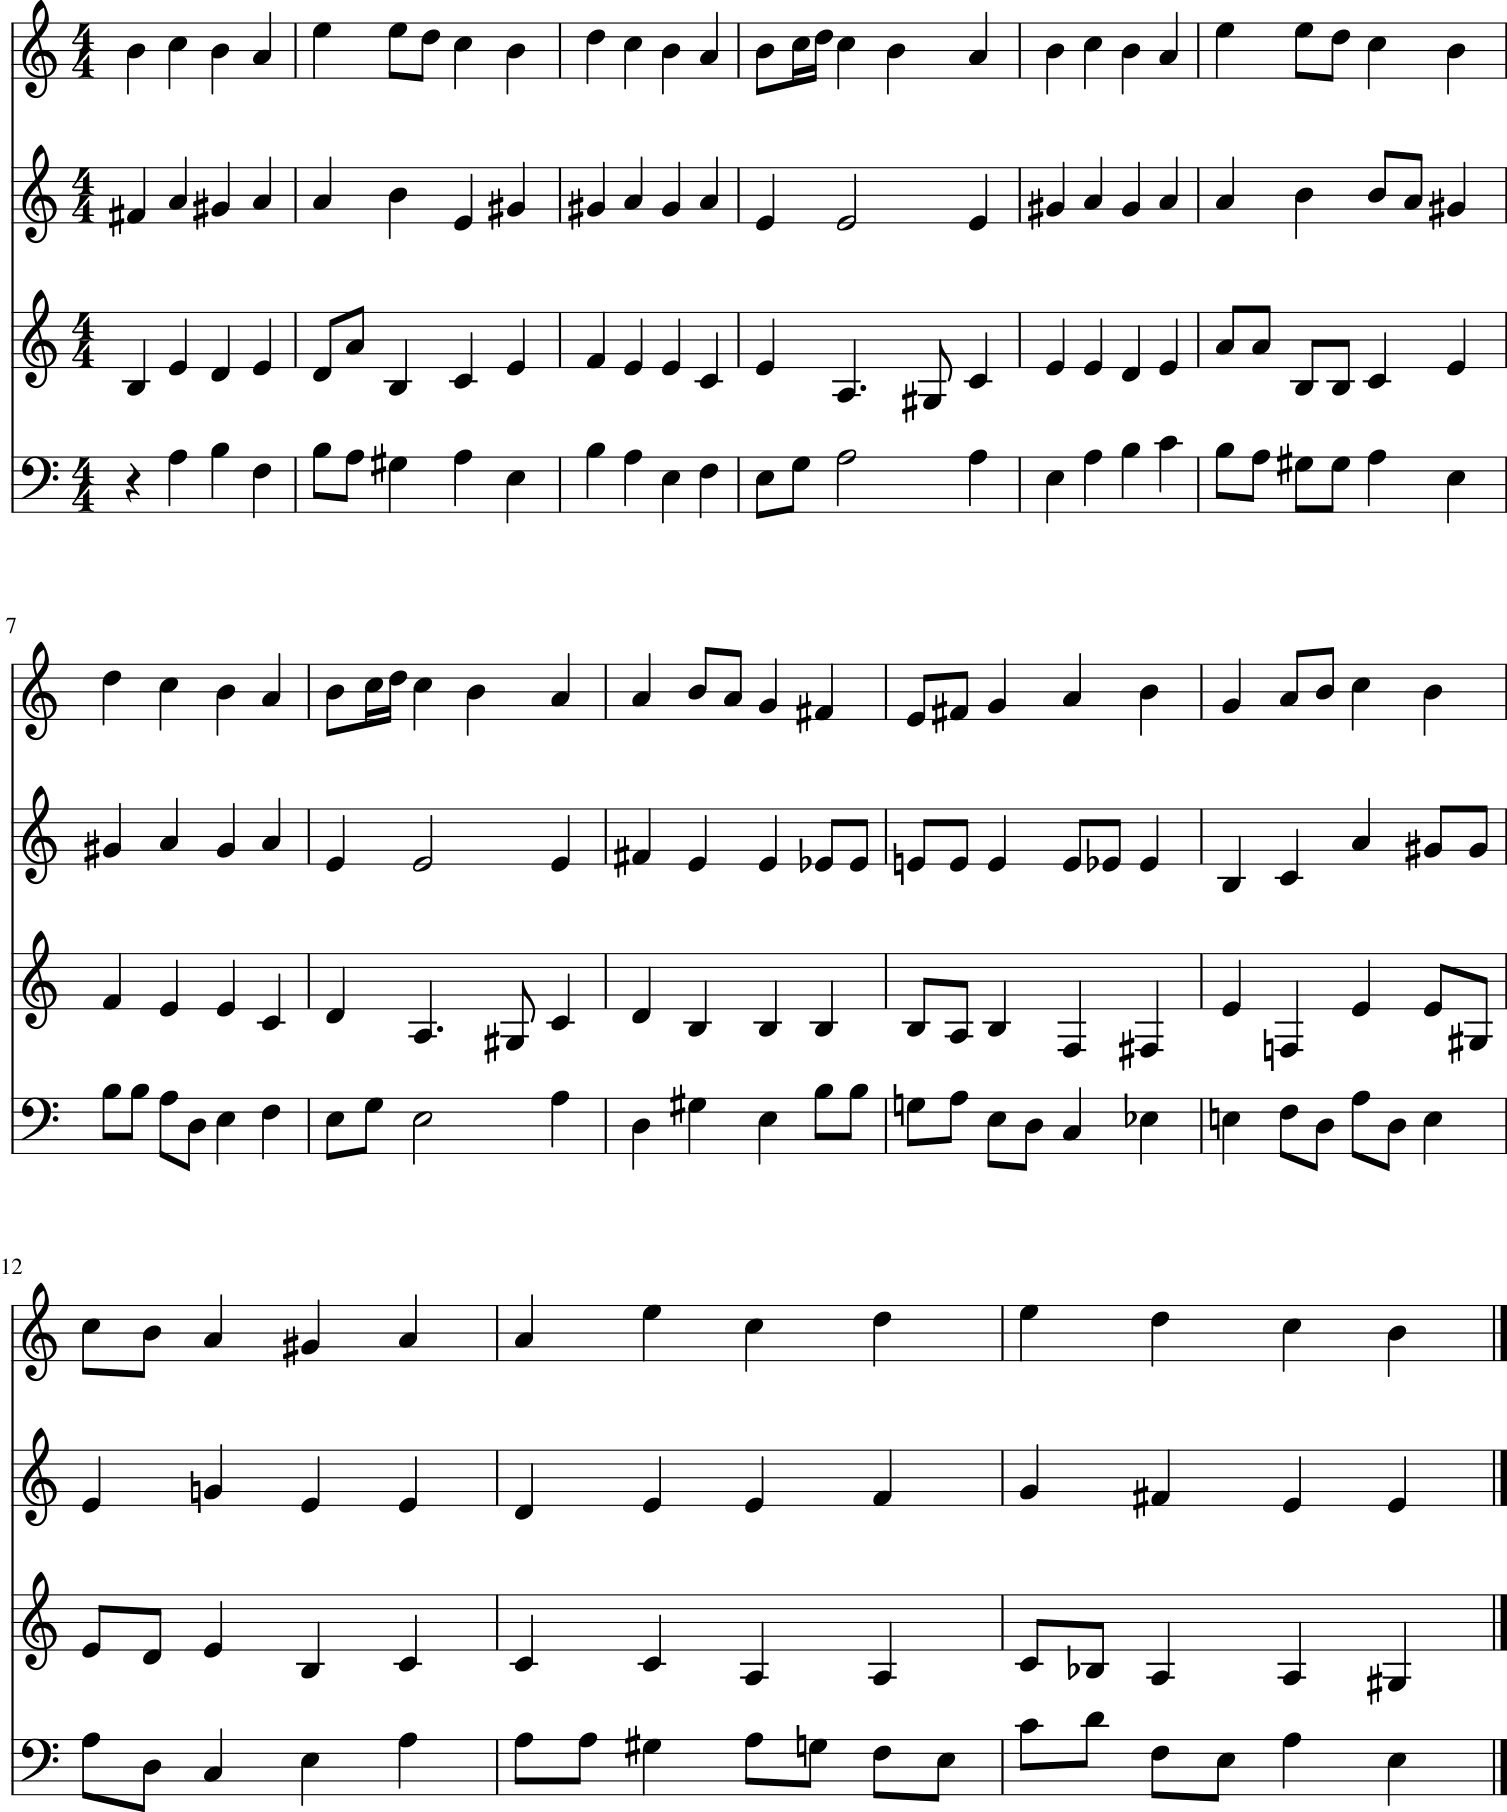

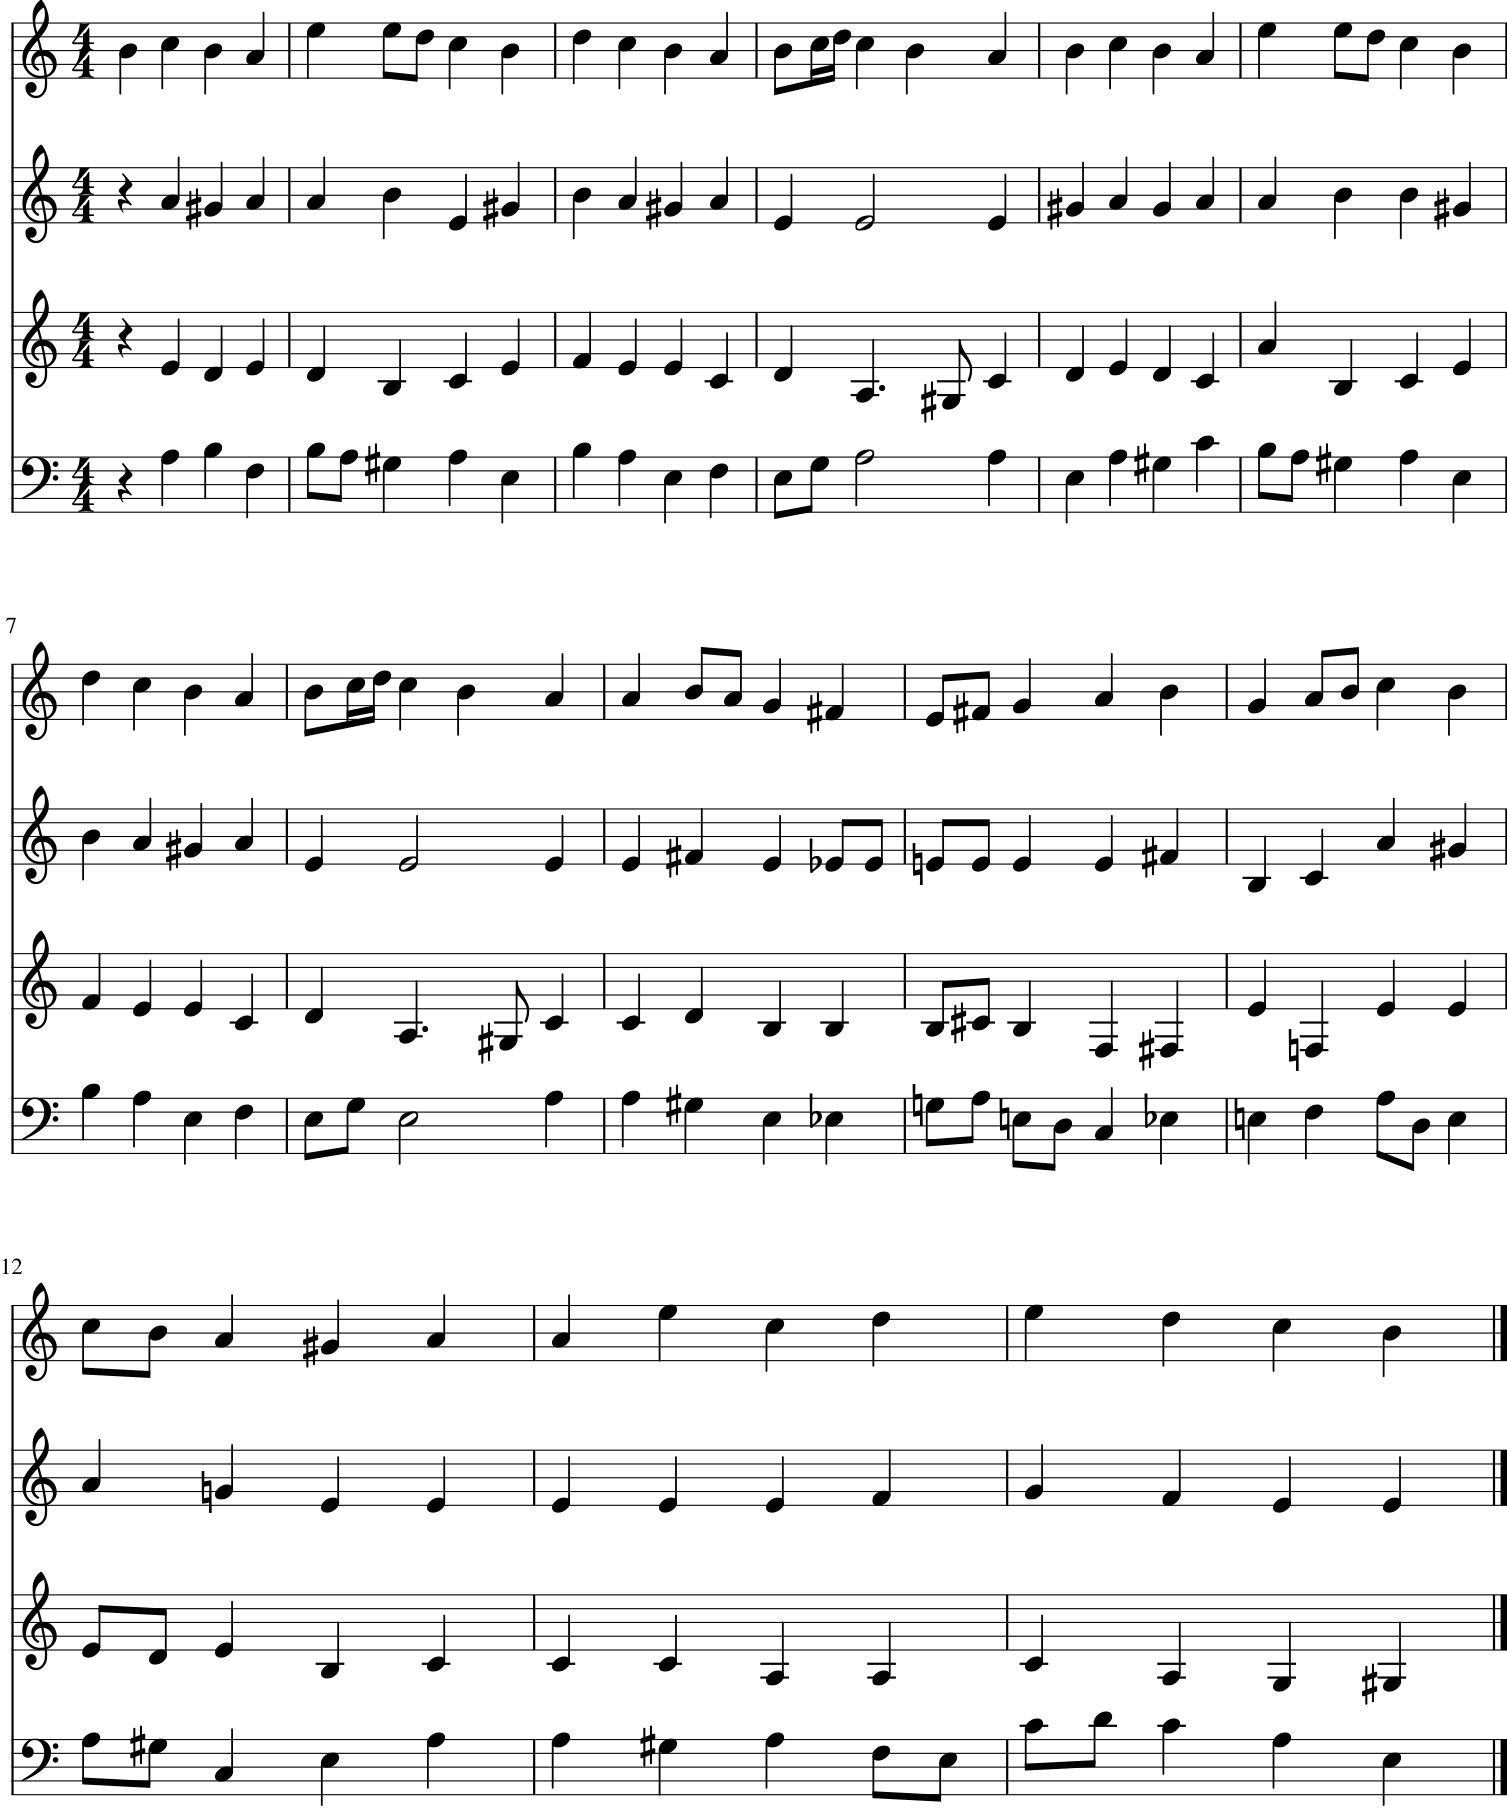

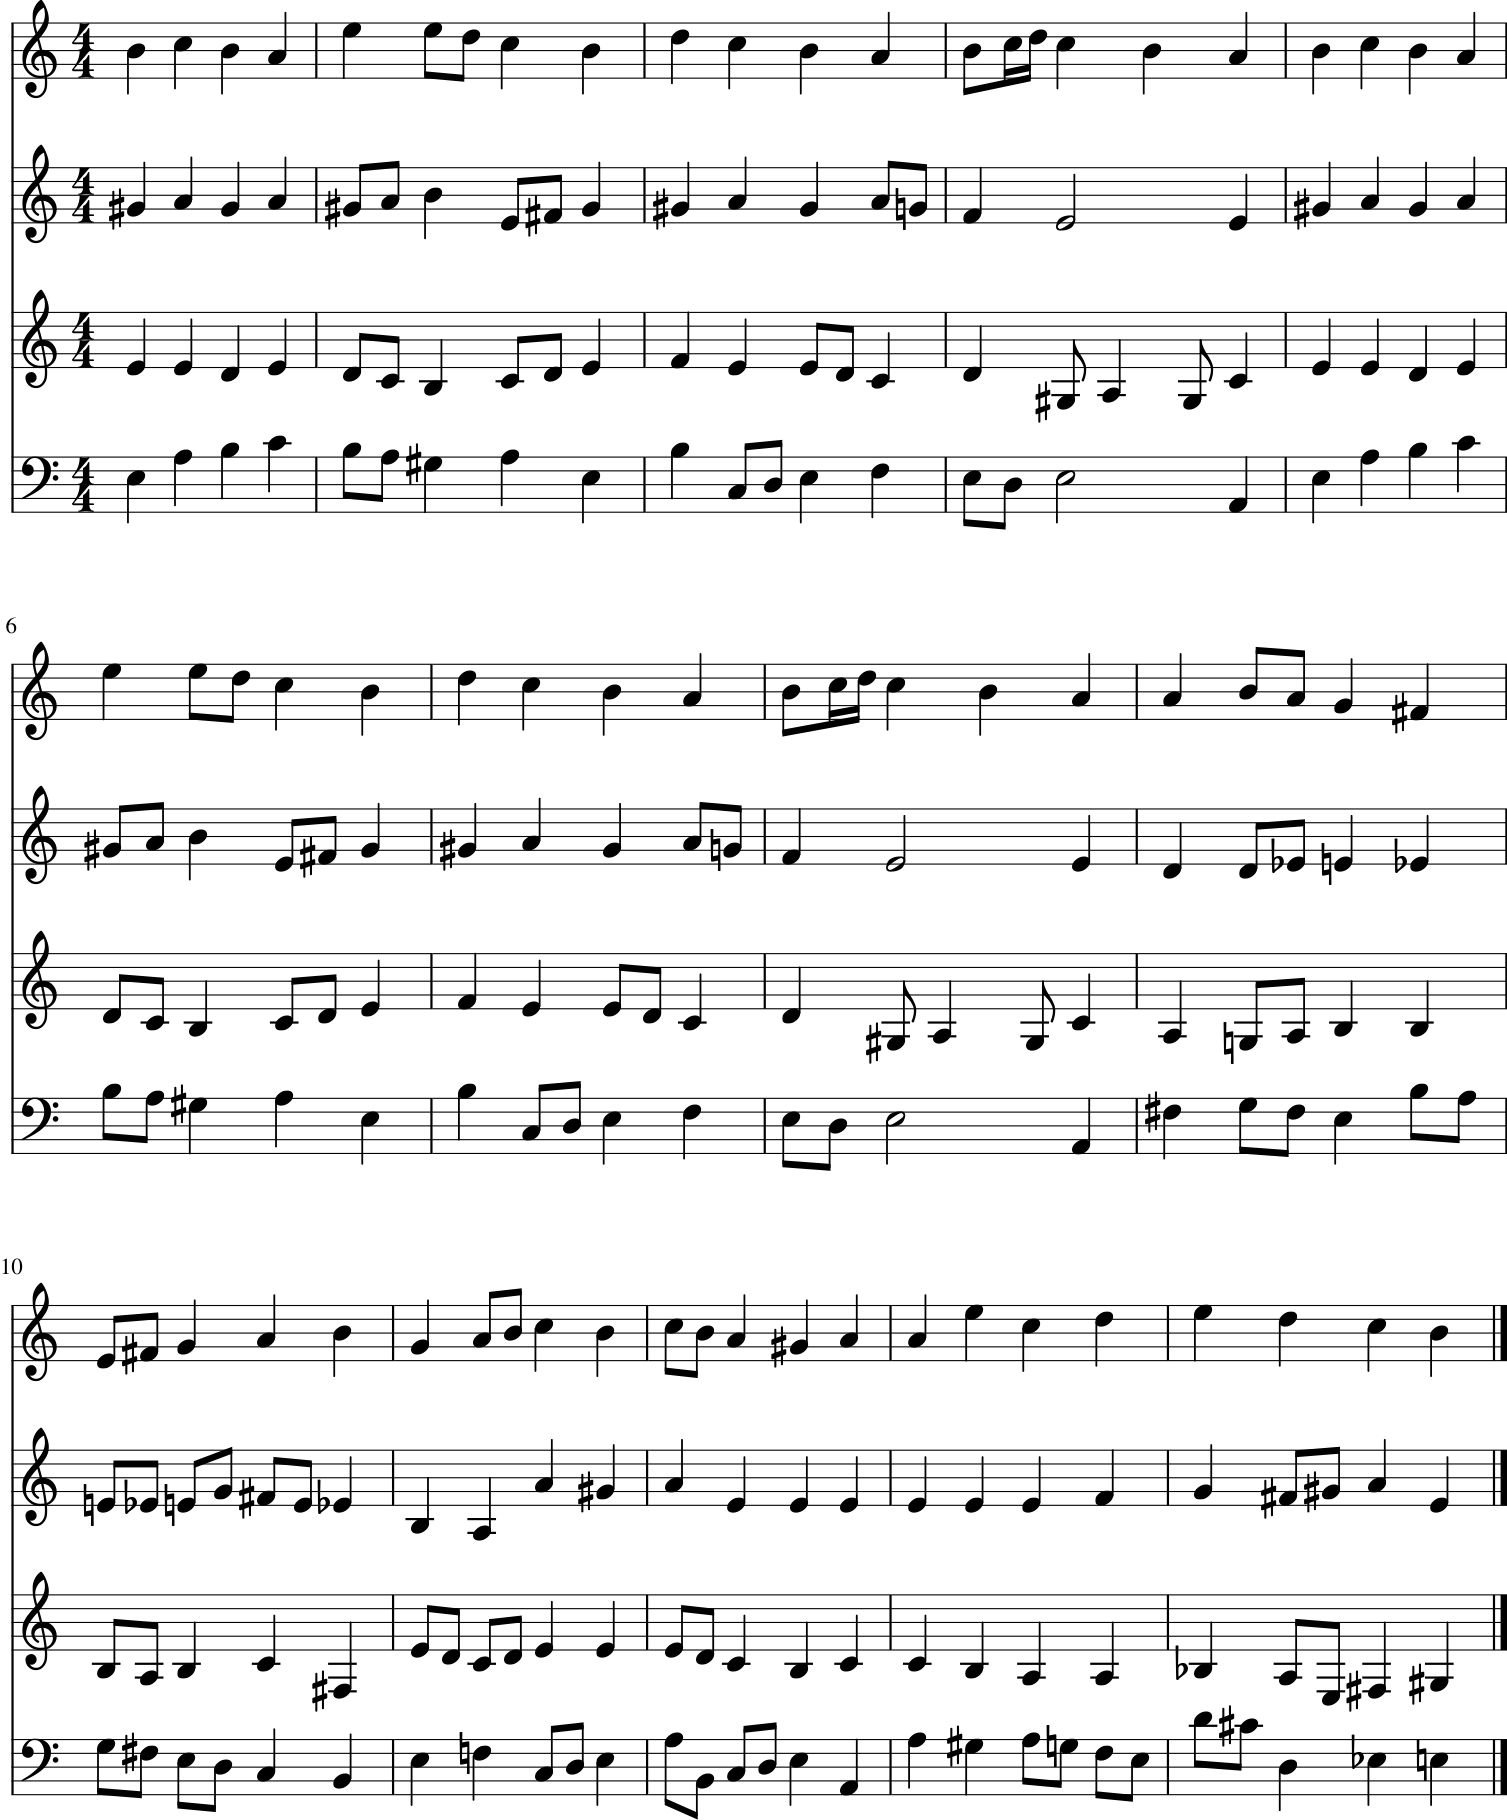

In [16]:
# 208 - 11 minor
# 190 3/4 major
songNum = 0
sc = createStream(predSongs[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')
#sc.show('text')

sc = createStream(predSongsSmooth[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')


sc = createStream(songs[songNum], 4)
sc.show()
sc.show('midi')



In [13]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/208songsMajorMinor-Names')

'/home/lucky/models/208songsMajorMinor-Names'

In [ ]:
print(len(songs))

In [120]:
all_saver = tf.train.Saver()
all_saver.restore(sess, "/home/lucky/models/208songsMajorMinor-Names")


INFO:tensorflow:Restoring parameters from /home/lucky/models/208songsMajorMinor-Names


In [ ]:
prediction_saver = tf.train.Saver([model.prediction])
predicition_saver.save(sess, '/home/lucky/models/208songsMajorMinor-2-prediction')

In [122]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/Brahms')

'/home/lucky/models/Brahms'